<h1>ENSO Diagnostics (Do Not Distribute)</h1>

In [1]:
import os
import sys

# Point to root directory of repository
root_dir = os.path.join(os.getcwd(), '..')
if root_dir not in sys.path:
    sys.path.insert(0, root_dir)
    
from src.datareader import datareader as dr
from src.util import util, stats

<h5>User Configurables</h5>

In [2]:
ufs_model = 'beta.0.1'
ufs_var = 'tsfc'
era5_var = 'sea_surface_temperature'
time_range = ("1994-02-01","2021-12-31T23")
initmonths = (11,)

region = {
    'latmin': -5.0,
    'latmax': 5.0,
    'lonmin': 190.0,
    'lonmax': 240.0
}

<h5>Get data readers</h5>

In [3]:
ufs_data_reader = dr.getDataReader(datasource='UFS', filename=f"experiments/phase_1/{ufs_model}/atm_monthly.zarr", model='atm')
era5_data_reader = dr.getDataReader(datasource='ERA5')

Reading data from s3://noaa-oar-sfsdev-pds/experiments/phase_1/beta.0.1/atm_monthly.zarr
No filename provided; deferring to default
Reading data from gs://gcp-public-data-arco-era5/ar/1959-2022-6h-512x256_equiangular_conservative.zarr


In [4]:
ufs_data_reader.describe(ufs_var)


Variable: tsfc
Dimensions: ('init', 'member', 'lead', 'lat', 'lon')
Shape: (60, 11, 12, 361, 720)
Attributes:
  - long_name: Temperature
  - units: K


In [5]:
era5_data_reader.describe(era5_var)


Variable: sea_surface_temperature
Dimensions: ('time', 'lat', 'lon')
Shape: (92044, 256, 512)
Attributes:
  - long_name: Sea surface temperature
  - short_name: sst
  - units: K


<h5>Get the monthly climatology for nino 3.4</h5>

In [6]:
# Enter a list of members, like [1, 2, 6, 8, ens_avg]
# Note that 'ens_avg' is a special keyword in the ensuing code.
# If you include 'ens_avg' in the list of members,
# then the Ensemble Average will be listed under member = -1
members = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'ens_avg']

In [7]:
%%capture captured_output
ufs_ds = util.retrieve_ufs_dataset(ufs_data_reader, ufs_var, time_range, members, region, initmonths=initmonths)

<h5>Get the corresponding ERA5 data</h5>

In [8]:
era5_ds = era5_data_reader.retrieve(var=era5_var,
                lat=(region['latmin'], region['latmax']),
                lon=(region['lonmin'], region['lonmax']),
                time=time_range)

<h5>Calculate climatology (this may take a couple minutes)</h5>

In [9]:
ufs_stats = stats.calc_climatology_anomaly(ufs_ds, area_mean=True, use_member_climatology=False)

In [10]:
era5_stats = stats.calc_climatology_anomaly(era5_ds, area_mean=True)

<h5>The calc_climatology_anomaly() function returns a dictionary of statistical datasets.<br>
The keys are:<br>
monthly_mean<br>
monthly_std<br>
climatology_mean<br>
climatology_std<br>
anomaly</h5>

<h2>Plot SST Index and Anomaly</h2>

Generating 4 panel(s).
Processing years 1994 to 1999
Processing years 2000 to 2009
Processing years 2010 to 2019
Processing years 2020 to 2021


<module 'matplotlib.pyplot' from '/home/thamzey/miniforge2/envs/ufs_model_evaluation_py311/lib/python3.11/site-packages/matplotlib/pyplot.py'>

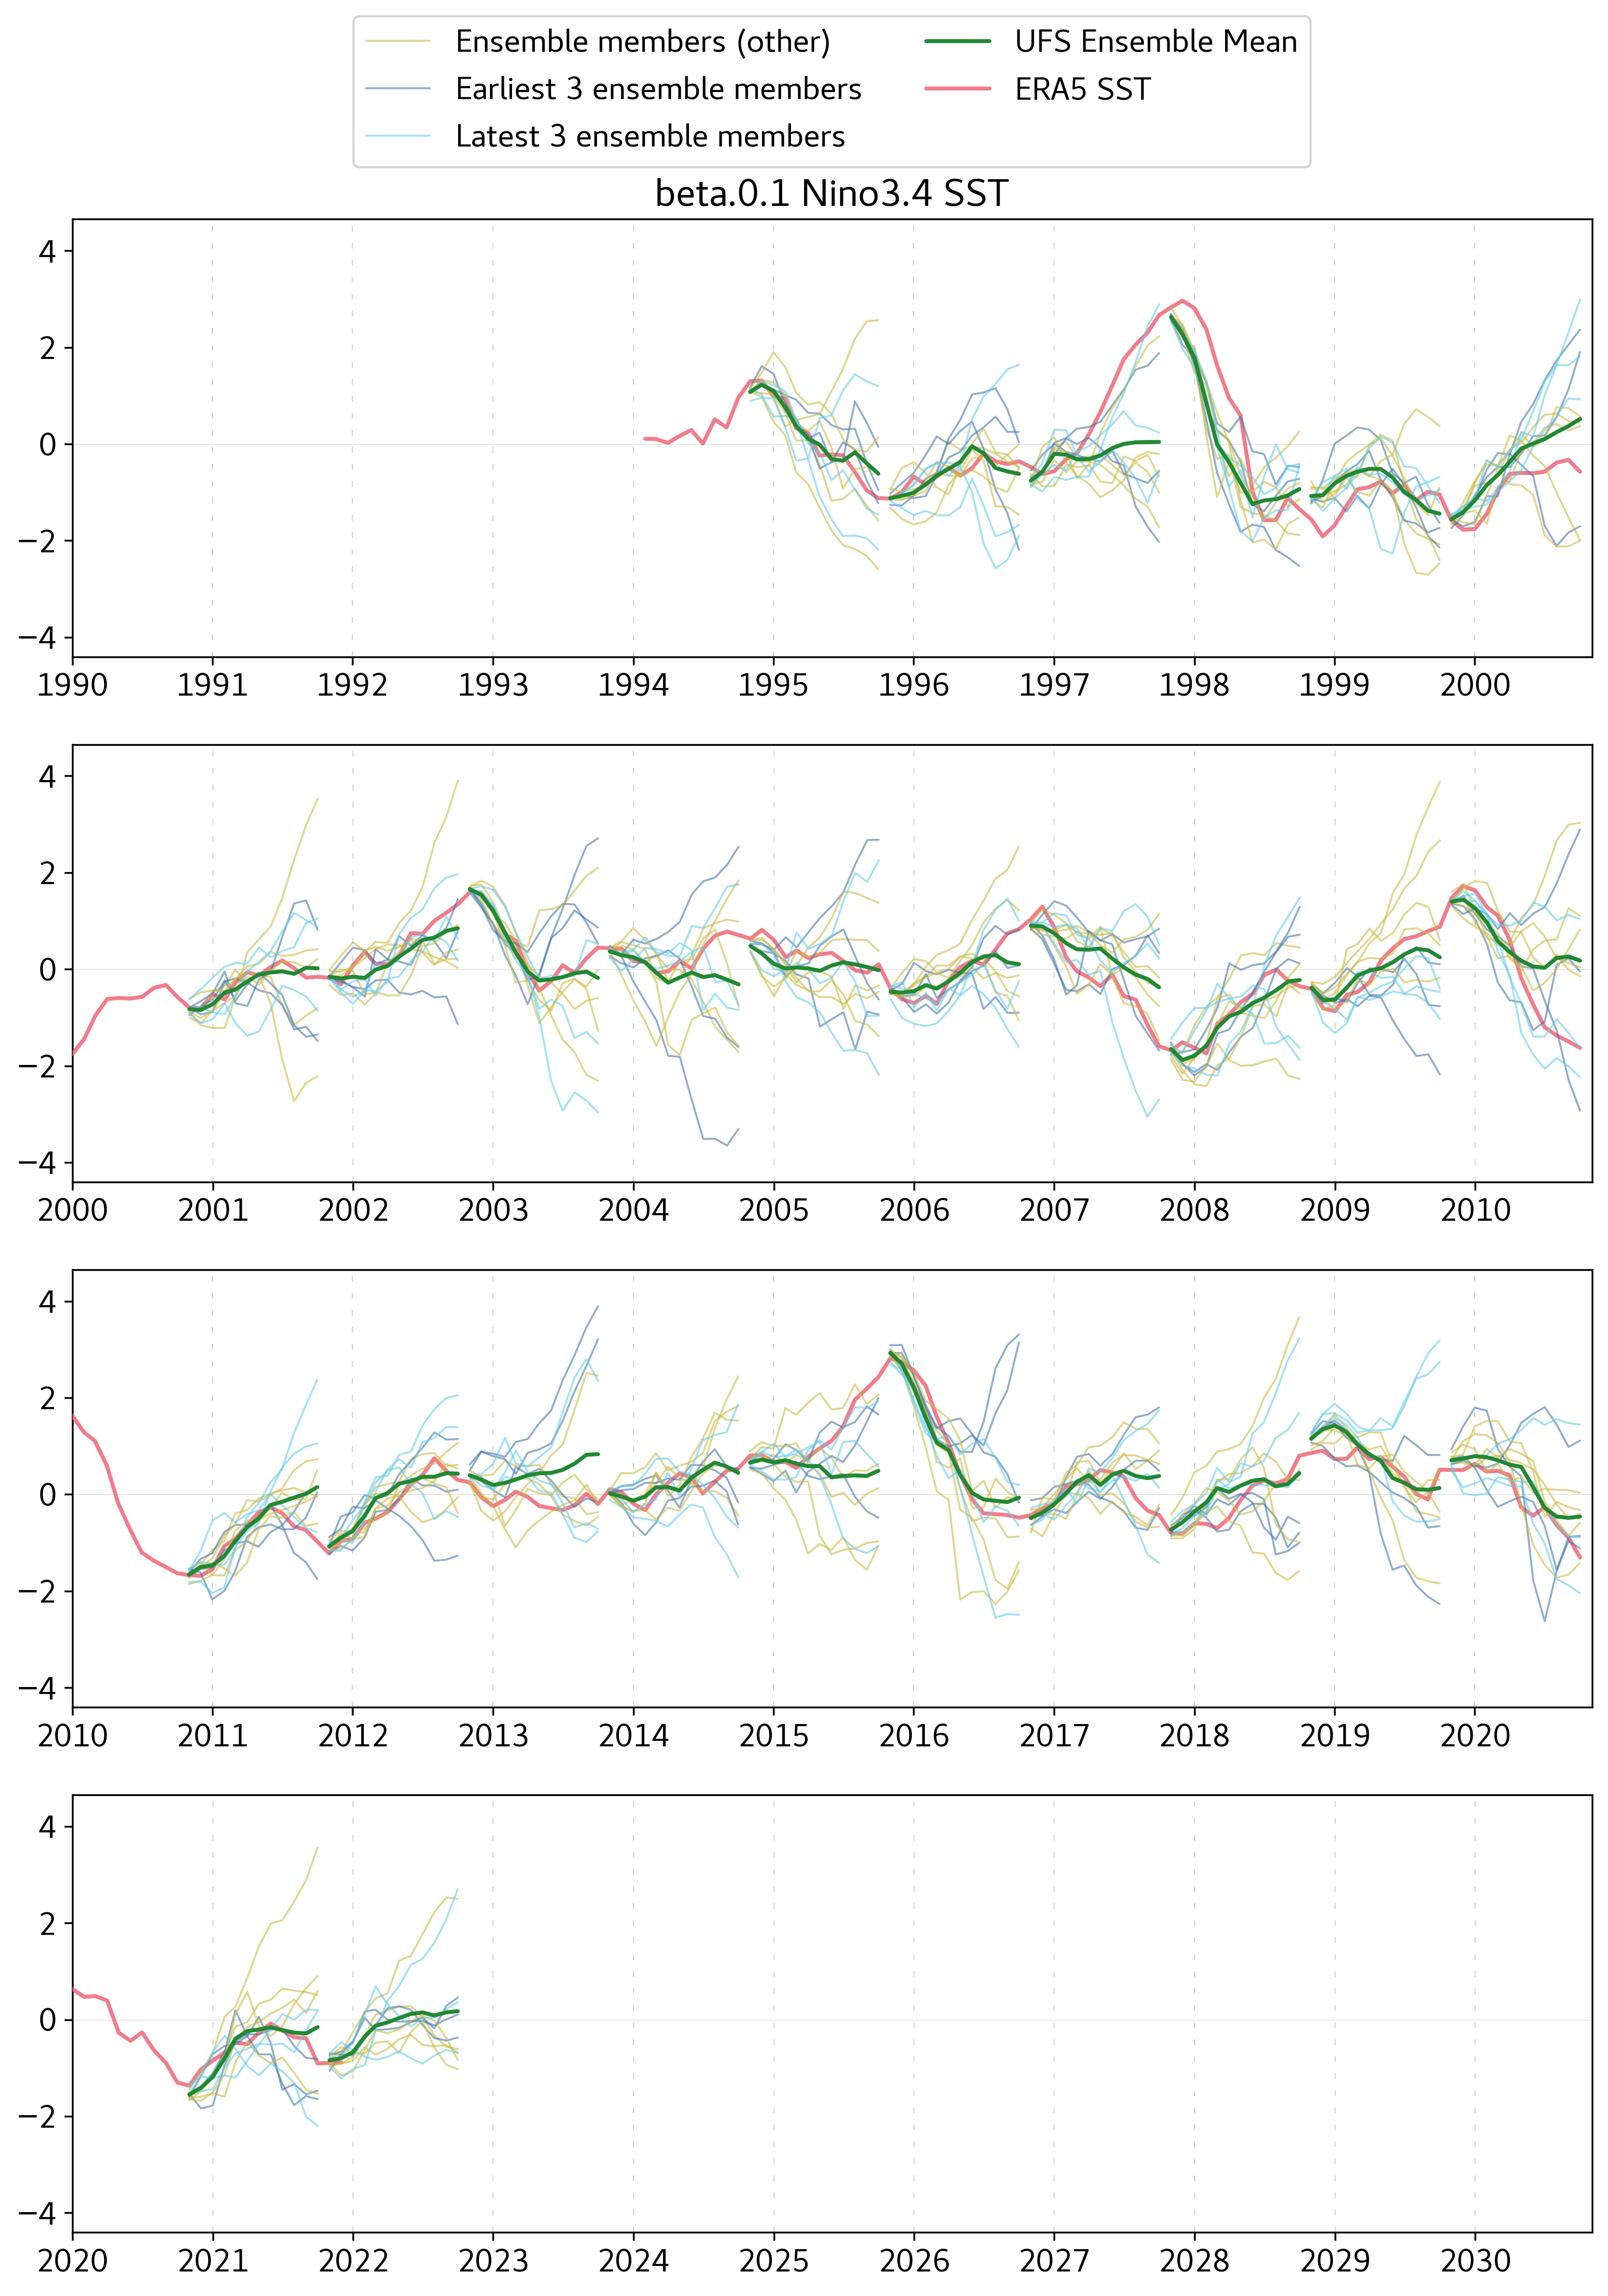

In [11]:
stats.plot_index_spaghetti(ufs_stats=ufs_stats,
                           verif_stats=era5_stats,
                           calc_anomaly=True,
                           use_member_climatology=False,
                           title=f'{ufs_model} Nino3.4 SST',
                           verif_label='ERA5 SST')